In [0]:
# !unzip horse2zebra.zip

In [0]:
# referred and taken some code from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix and https://github.com/aitorzip/PyTorch-CycleGAN

import numpy as np
import os, glob, warnings, cv2, joblib, random,sys
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,SequentialSampler,SubsetRandomSampler
import torch.optim as optim

import matplotlib.pyplot as plt
from skimage import io,transform
import pandas as pd
from PIL import Image
warnings.filterwarnings('ignore')
import itertools
from torch.autograd import variable

In [0]:
# A_path = r"E:\Sem3\AML\Assignments & Quiz\Assignment_5\Dataset_2\horse2zebra\train\A"
# B_path = r"E:\Sem3\AML\Assignments & Quiz\Assignment_5\Dataset_2\horse2zebra\train\B"

A_path = r"horse2zebra/train/A"
B_path = r"horse2zebra/train/B"

device='cuda'
# device = 'cpu'
n_workers = 0
batch_size = 1
height, width = 286, 286
crop_height, crop_width = 256, 256

transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#                                 transforms.Resize((height,width)),
#                                 transforms.RandomCrop((crop_height,crop_width)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])


A_data = datasets.ImageFolder(root=A_path,transform=transform)
B_data = datasets.ImageFolder(root=B_path,transform=transform)

A_loader = DataLoader(A_data, batch_size=batch_size, num_workers=n_workers)
B_loader = DataLoader(B_data, batch_size=batch_size, num_workers=n_workers)

# for i,(images, label) in enumerate(A_loader,0):
#     plt.imshow(images[0].permute(1,2,0))
#     plt.show()
#     if(i==1):
#         break
        
# for i,(images, label) in enumerate(B_loader,0):
#     plt.imshow(images[0].permute(1,2,0))
#     plt.show()
#     if(i==1):
#         break

### Architecture

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, 64, 7),
                 nn.InstanceNorm2d(64),
                 nn.ReLU(inplace=True)]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)
        
#         self.network = nn.Sequential()
        

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        
        self.network = nn.Sequential(nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                                     nn.LeakyReLU(0.2, inplace=True),
                                     
                                     nn.Conv2d(64, 128, 4, stride=2, padding=1),
                                     nn.InstanceNorm2d(128),
                                     nn.LeakyReLU(0.2, inplace=True),
                                     
                                     nn.Conv2d(128, 256, 4, stride=2, padding=1),
                                     nn.InstanceNorm2d(256),
                                     nn.LeakyReLU(0.2, inplace=True),
                                     
                                     nn.Conv2d(256, 512, 4, padding=1),
                                     nn.InstanceNorm2d(512),
                                     nn.LeakyReLU(0.2, inplace=True),
                                     
                                     nn.Conv2d(512, 1, 4, padding=1)# FCN classification layer
                                    )

    def forward(self, x):
        x =  self.network(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

class ReplayBuffer():
    def __init__(self, max_size=10):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
#         return Variable(torch.cat(to_return))
        return torch.cat(to_return)

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [0]:
input_nc=3
output_nc = 3
lr = 0.0002
batchSize = 1
size = 256

netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)
netD_A = Discriminator(input_nc)
netD_B = Discriminator(output_nc)

netG_A2B.to(device)
netG_B2A.to(device)
netD_A.to(device)
netD_B.to(device)

criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

n_epochs = 100
epoch=0
decay_epoch=50

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

# Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
Tensor = torch.cuda.FloatTensor
# Tensor = torch.Tensor
input_A = Tensor(batchSize, input_nc, size, size)
input_B = Tensor(batchSize, output_nc, size, size)

target_real = Tensor(batchSize).fill_(1.0)
target_fake = Tensor(batchSize).fill_(0.0)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [5]:
epochs=15
loss_G_plt = []
loss_identity_A_plt=[]
loss_identity_B_plt=[]
loss_G_identity_plt = []

loss_GAN_A2B_plt = []
loss_GAN_B2A_plt = []
loss_G_GAN_plt = []

loss_cycle_ABA_plt = []
loss_cycle_BAB_plt = []
loss_G_cycle_plt = []

loss_D_A_plt = []
loss_D_B_plt = []
loss_D_plt = []

for epoch in range(epochs):
    for i, (realA, realB) in enumerate(zip(A_loader, B_loader)):
        # Set model input
        # print(realA[0].shape)
        real_A = input_A.copy_(realA[0])
        real_B = input_B.copy_(realB[0])

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()

#         print('loss_G', torch.FloatTensor(loss_G.item()), '| loss_G_identity',(loss_identity_A.item() + loss_identity_B.item()),'| loss_G_GAN', (loss_GAN_A2B.item() + loss_GAN_B2A.item()),'| loss_G_cycle', (loss_cycle_ABA.item() + loss_cycle_BAB.item()), '| loss_D', (loss_D_A.item() + loss_D_B.item()))
    print(epoch,': L_G:', loss_G.item(), '| L_G_id.:',(loss_identity_A + loss_identity_B).item(),'| L_G_GAN:', (loss_GAN_A2B + loss_GAN_B2A).item(),'| L_G_cycle:', (loss_cycle_ABA + loss_cycle_BAB).item(), '| L_D:', (loss_D_A+ loss_D_B).item())
    loss_G_plt.append(loss_G.item())
    loss_identity_A_plt.append(loss_identity_A.item())
    loss_identity_B_plt.append(loss_identity_B.item())
    loss_G_identity_plt.append(loss_identity_A.item()+loss_identity_B.item())

    loss_GAN_A2B_plt.append(loss_GAN_A2B.item())
    loss_GAN_B2A_plt.append(loss_GAN_B2A.item())
    loss_G_GAN_plt.append(loss_GAN_A2B.item() + loss_GAN_B2A.item())

    loss_cycle_ABA_plt.append(loss_cycle_ABA.item())
    loss_cycle_BAB_plt.append(loss_cycle_BAB.item())
    loss_G_cycle_plt.append(loss_cycle_ABA.item() + loss_cycle_BAB.item())

    loss_D_A_plt.append(loss_D_A.item())
    loss_D_B_plt.append(loss_D_B.item())
    loss_D_plt.append(loss_D_A.item() + loss_D_B.item())

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

0 : L_G: 8.424875259399414 | L_G_id.: 2.527878522872925 | L_G_GAN: 0.4518752098083496 | L_G_cycle: 5.445122241973877 | L_D: 0.34011828899383545
1 : L_G: 8.205333709716797 | L_G_id.: 2.2678818702697754 | L_G_GAN: 0.9384846091270447 | L_G_cycle: 4.998967170715332 | L_D: 0.4492664933204651
2 : L_G: 7.966972827911377 | L_G_id.: 2.062452793121338 | L_G_GAN: 1.3488659858703613 | L_G_cycle: 4.555654525756836 | L_D: 0.5239294171333313
3 : L_G: 8.215192794799805 | L_G_id.: 2.1716222763061523 | L_G_GAN: 1.4545269012451172 | L_G_cycle: 4.589044094085693 | L_D: 0.4305124282836914
4 : L_G: 8.213871002197266 | L_G_id.: 2.0189709663391113 | L_G_GAN: 1.8909471035003662 | L_G_cycle: 4.303952217102051 | L_D: 0.5690851211547852
5 : L_G: 7.635962963104248 | L_G_id.: 2.015946865081787 | L_G_GAN: 1.2520674467086792 | L_G_cycle: 4.367948532104492 | L_D: 0.24286046624183655
6 : L_G: 7.5173797607421875 | L_G_id.: 2.0325560569763184 | L_G_GAN: 1.1883764266967773 | L_G_cycle: 4.29644775390625 | L_D: 0.4105882644

In [7]:
# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor
input_A = Tensor(batchSize, input_nc, size, size)
input_B = Tensor(batchSize, output_nc, size, size)
A_path_test = 'horse2zebra/test/A/'
B_path_test = 'horse2zebra/test/B/'

A_data_test = datasets.ImageFolder(root=A_path_test,transform=transform)
B_data_test = datasets.ImageFolder(root=B_path_test,transform=transform)

A_loader_test = DataLoader(A_data_test, batch_size=batch_size, num_workers=n_workers)
B_loader_test = DataLoader(B_data_test, batch_size=batch_size, num_workers=n_workers)

###### Testing######
# Create output dirs if they don't exist
if not os.path.exists('output/A'):
    os.makedirs('output/A')
if not os.path.exists('output/B'):
    os.makedirs('output/B')

for i, (realA, realB) in enumerate(zip(A_loader_test, B_loader_test)):
    # Set model input
    real_A = input_A.copy_(realA[0])
    real_B = input_B.copy_(realB[0])

    # Generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

    # Save image files
    save_image(fake_A, 'output/A/%04d.png' % (i+1))
    save_image(fake_B, 'output/B/%04d.png' % (i+1))

    sys.stdout.write('\rGenerated images %04d of %04d' % (i+1, len(A_loader)))

sys.stdout.write('\n')

Generated images 0005 of 0100


In [0]:
# !zip -r output.zip output

In [0]:
def plot(values,title,xaxis='epochs',yaxis='Loss',color='b'):
    plt.title(title)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.plot(np.arange(len(values)),values,color=color)
    plt.show()

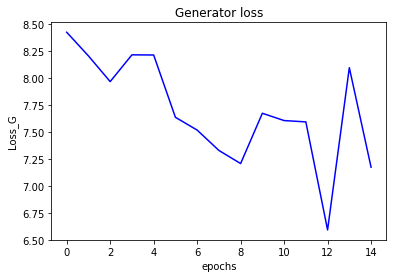

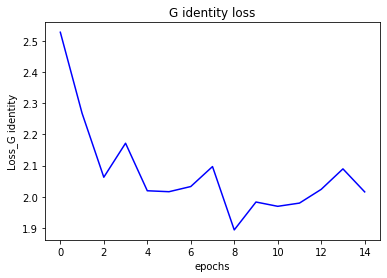

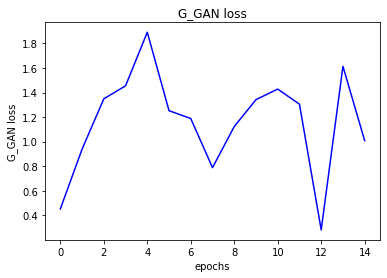

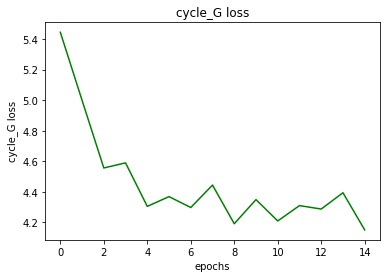

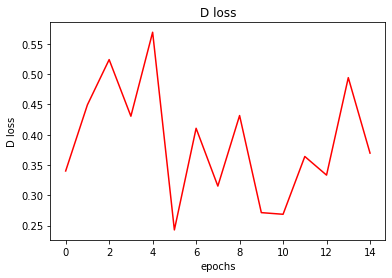

In [29]:
import matplotlib.pyplot as plt

plot(loss_G_plt,'Generator loss','epochs','Loss_G')
# plot(loss_identity_A_plt,'A identity loss','epochs','Loss_A identity')
# plot(loss_identity_B_plt,'B identity loss','epochs','Loss_B identity')
plot(loss_G_identity_plt,'G identity loss','epochs','Loss_G identity')
# plot(loss_GAN_A2B_plt,'G_A2B loss','epochs','G_A2B loss')
# plot(loss_GAN_B2A_plt,'G_B2A loss','epochs','G_B2A loss')
plot(loss_G_GAN_plt,'G_GAN loss','epochs','G_GAN loss')
# plot(loss_cycle_ABA_plt,'cycle_ABA loss','epochs','cycle_ABA loss','g')
# plot(loss_cycle_BAB_plt,'cycle_BAB loss','epochs','cycle_BAB loss','g')
plot(loss_G_cycle_plt,'cycle_G loss','epochs','cycle_G loss','g')
# plot(loss_D_A_plt,'D_A loss','epochs','D_A loss','r')
# plot(loss_D_B_plt,'D_B loss','epochs','D_B loss','r')
plot(loss_D_plt,'D loss','epochs','D loss','r')

In [14]:
# import joblib

# joblib.dump(netG_A2B,'netG_A2B.sav')
# joblib.dump(netG_B2A,'netG_B2A.sav')
# joblib.dump(netD_A,'netD_A.sav')
# joblib.dump(netD_B,'netD_B.sav')


# joblib.dump(loss_G_plt,'loss_G_plt.sav')
# joblib.dump(loss_identity_A_plt,'loss_identity_A_plt.sav')
# joblib.dump(loss_identity_B_plt,'loss_identity_B_plt.sav')
# joblib.dump(loss_G_identity_plt,'loss_G_identity_plt.sav')
# joblib.dump(loss_GAN_A2B_plt,'loss_GAN_A2B_plt.sav')
# joblib.dump(loss_GAN_B2A_plt,'loss_GAN_B2A_plt.sav')
# joblib.dump(loss_G_GAN_plt,'loss_G_GAN_plt.sav')
# joblib.dump(loss_cycle_ABA_plt,'loss_cycle_ABA_plt.sav')
# joblib.dump(loss_cycle_BAB_plt,'loss_cycle_BAB_plt.sav')
# joblib.dump(loss_G_cycle_plt,'loss_G_cycle_plt.sav')
# joblib.dump(loss_D_A_plt,'loss_D_A_plt.sav')
# joblib.dump(loss_D_B_plt,'loss_D_B_plt.sav')
# joblib.dump(loss_D_plt,'loss_D_plt.sav')

['loss_D_plt.sav']